In [1]:
%reload_ext autoreload
%autoreload 2

import copy
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from scipy.linalg import lu_factor, lu_solve

from hw1 import *

## Mathematical and Numerical Physics
### Numerical part 1
#### Kevin Vonk, s1706896, _Nov - Dec 2020_

## Problem 1
### a.
The Euler Forward scheme has been implemented in Python using the ways discussed in the lecture notes. We will run the simulation using $n_x \in \{8, 16, 32\}$. The amount of timesteps used will be computed using the Von Neumann stability analysis, such that the minimum required timesteps needed for a stable result are used. This will lead to some cases where the result hasn't fully converged yet, but it provides a worst-case scenario. The generating code and resulting figures are found below. Here, we will also discuss the results.

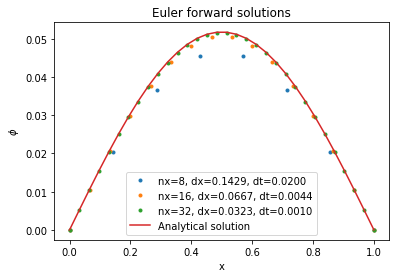

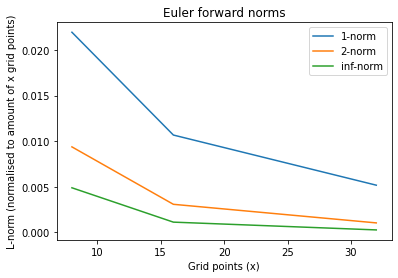

In [2]:
# Define some constants
ords = (1, 2, np.inf)
norms = [[] for ord in ords]

steps = (8, 16, 32)
x = (0, 1)
t = (0, 0.6)
M = 0.5

# Compute the initial conditions and analytical solution
ic = lambda x, _: np.sin(np.pi * x)
ana = lambda x, t: np.exp(-M * np.pi**2 * t) * np.sin(np.pi * x)
err = lambda num, ana: num - ana

# Compute the solution for all given grid points in x
for nx in steps:
    nt = EulerForward1D.stable_time_steps(x, t, nx, M)
    ef = EulerForward1D(xbounds = x, tbounds = t, nx = nx, nt = nt, ic = ic, M = M)

    solution = ef.fullsolve()
    error = err(solution, ana(ef.x, t[1]))
    norms = [[*norm, np.mean(np.linalg.norm(error, ord=ord))] for norm, ord in zip(norms, ords)]
    
    plt.plot(ef.x, solution, '.', label=f"nx={nx}, dx={ef.dx:.4f}, dt={ef.dt:.4f}")

# Plot the results
plt.plot(ef.x, ana(ef.x, t[1]), label="Analytical solution")
plt.legend()
plt.xlabel("x")
plt.ylabel(r"$\phi$")
plt.title("Euler forward solutions")

plt.figure(2)
for norm, ord in zip(norms, ords):
    plt.plot(steps, norm, label=f"{ord}-norm")

plt.legend()
plt.xlabel("Grid points (x)")
plt.ylabel("L-norm (normalised to amount of x grid points)")
plt.title("Euler forward norms");

As we can observe from the numerical solutions, when we increase the amount of grid points we converge closer to the analytical solution. Note that increasing the amount of positional grid points also increases the amount of time grid points in order for the numerical stability to hold. The amount of grid points is computed automatically using the Von Neumann method, minimising the amount of required time grid points whilst still providing numerical stability.

The computed averaged / normalised norms show a similar picture, where the increase in grid points yield smaller errors.

### b.
Now, we implement the DuFort Frankel method. We need to ensure that $\frac{\Delta t}{\Delta x} \rightarrow 0$. This can be reinterpreted as $\Delta t \ll \Delta x$. A reasonable approximation to this is taking $\Delta t = 10^{-2} \Delta x$. This will be our minimum stability requirement. Further plotting and interpretation is identical to the Euler Forward case.

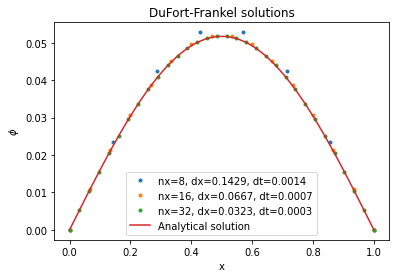

In [3]:
# Compute the solution for the various given grid steps
for nx in steps:
    nt = DuFortFrankel1D.stable_time_steps(x, t, nx)
    dff = DuFortFrankel1D(xbounds = x, tbounds = t, nx = nx, nt = nt, ic = ic, M = M)
    dff.fullsolve()

    plt.plot(dff.x, dff.solution, '.', label=f"nx={nx}, dx={dff.dx:.4f}, dt={dff.dt:.4f}")

# Plot the results
plt.plot(ef.x, ana(ef.x, t[1]), label="Analytical solution")
plt.legend()
plt.xlabel("x")
plt.ylabel(r"$\phi$")
plt.title("DuFort-Frankel solutions");

We can see from the resulting plot that the DuFort-Frankel method also nicely converges to the analytical solution. Of note here is that the DuFort-Frankel method seems to converge to the analytical solution using less positional grid points. However, the flip side of this is that our time step is about 6 times smaller, so the increased accuracy could just as well come from this decreased time step. One could argue that the factor $10^{2}$ difference between the time steps and the positional steps needn't be this big, but there is no clear cut limit given that needs to be upheld. In any case, this solution method seems stable using these paramters and provides a good convergence to the analytical solution.

### c.
In order to show that the Euler backwards method is stable, let us first consider the Euler backwards method itself,

\begin{equation}
    -\alpha \phi^{n+1}_{i+1} + (1 + 2\alpha) \phi^{n+1}_i - \alpha \phi^{n+1}_{i-1} = \phi^n_i.
    \label{eq:1c-eb}
\end{equation}

Applying the Von Neumann stability method to this equation means replacing $\phi^n_i$ with its Fourier mode,

\begin{equation}
    \psi^n_i = \lambda^n e^{jki\Delta x}, 
    \label{eq:1c-fourier}
\end{equation}

where $j$ indicates the complex number, and $i$ the positional index. Filling in eq. \eqref{eq:1c-fourier} into eq. \eqref{eq:1c-eb} yields,

\begin{equation}
    -\alpha \lambda^{n+1} e^{jk\Delta x}e^{jki\Delta x} + (1+2\alpha)\lambda^{n+1}e^{jki\Delta x} - \alpha \lambda^{n+1} e^{-jk\Delta x} e^{jki\Delta x} = \lambda^n e^{jki\Delta x}.
    \label{eq:1c-ebf-start}
\end{equation}

Dividing \eqref{eq:1c-ebf-start} by $\lambda^n e^{jki\Delta x}$,
\begin{align*}
    -\alpha \lambda (k) e^{jk\Delta x} + (1 - 2\alpha)\lambda (k) - \alpha \lambda (k)e^{-jk\Delta x} &= 1 \\
    \lambda (k) \left[-\alpha e^{jk\Delta x} -\alpha e^{-jk\Delta x} + 1 - 2\alpha\right] &= 1 \\
    \lambda(k)\left[-2\alpha\cos(k\Delta x) - 2\alpha + 1\right] &= 1 \\
    \frac{1}{1 - 2\alpha \left(\cos(k\Delta x) - 1\right)} &= \lambda(k).
\end{align*}

For the scheme to be stable, we have the constraint that $\lvert\lambda(k)\rvert \leq 1$. In this case, that means that $\lvert 1 - 2\alpha \left(\cos(k\Delta x) - 1\right) \rvert \geq 1$. Squaring this to get rid of the absolute value and solving,

\begin{align*}
    1 - 4\alpha\left[\cos(k\Delta x) - 1\right] + 4\alpha^2\left[\cos(k\Delta x)-1\right] &\geq 1 \\
    4\alpha\left[\cos(k\Delta x - 1\right]\left(\alpha\left[\cos(k\Delta x) - 1\right]-1\right) &\geq 0 \\
    4\alpha\left[\cos(k\Delta x) - 1\right] \geq 0 &\vee \alpha\left[\cos(k\Delta x) - 1\right] \geq 0 \\
    \rightarrow \alpha \geq 0 &\vee \alpha \geq \frac{1}{\cos(k\Delta x) - 1} \\
    &\rightarrow \alpha \geq 0 \; \text{(since $\cos(k\Delta x) \leq 1$)}.
\end{align*}

So, as long as $\alpha$ is positive, the solution will converge. Looking at $\alpha$,
\begin{equation*}
    \alpha = M\frac{\Delta t}{(\Delta x)^2},
\end{equation*}
we can see that $\Delta x$ can be any value, and that $\Delta t$ and $M$ need to be positive. Since these two will always be positive, we can conclude that the Euler backwards method is unconditionally stable.


### d.
The general form of the matrix $A$ can be written as such,

\begin{equation*}
    A = \begin{bmatrix}
        1 + 2\alpha & -\alpha & 0 & \cdots & 0 \\
        -\alpha & 1 + 2\alpha & -\alpha & \ddots & \vdots \\
        0 & -\alpha & 1 + 2\alpha & \ddots & \vdots \\
        \vdots & \ddots & \ddots & \ddots & \vdots
    \end{bmatrix}.
\end{equation*}

This matrix will be generated by the Euler Backwards solver, and we will compare the results of numpy's inversion, scipy's LU decomposition and our custom tridiagonal solver.

In [4]:
nx = 8
nt = 50

eb = EulerBackward1D(xbounds = x, tbounds = t, nx = nx, nt = nt, ic = ic, M = M, nx_as_interval=True)

matrix = eb.A

# Inversion
phi_inv = np.linalg.inv(matrix) @ eb.solution

# LU decomposition
phi_lu = lu_solve(lu_factor(matrix), eb.solution)

# Tridiagonal
phi_tri = next(eb.solve())

# Check if all results are identical (we are dealing with floats, so identical within an error)
if np.allclose(phi_inv[1:-1], phi_lu[1:-1]) and np.allclose(phi_inv[1:-1], phi_tri[1:-1]):
    print("All solution methods (excl. boundaries) provide identical results")
elif np.allclose(phi_inv, phi_lu):
    print("Only library solutions provide identical results")
else:
    print("The solution methods are not equal")

Only library solutions provide identical results


As we can see, all three solution methods provide identical results. The reason we exclude the boundary conditions when checking for the solution equalities is because the solve function automatically forces the boundary conditions to be applied on the solution, whereas in the solutions provided by the libraries this is not yet done.

We will use the tridiagonal solver to solve the Euler Backwards method, since that is the one we implemented in the Euler Backwards solver already. As in the previous exercises, the convergence will be proven by showing that higher amounts of spatial grid points yield a result closer to the analytical solution. We will keep the time step constant in this case.

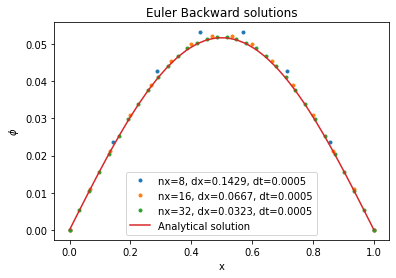

In [5]:
# Compute the solution for the various given grid steps
nt = 1250
for nx in steps:
    eb = EulerBackward1D(xbounds = x, tbounds = t, nx = nx, nt = nt, ic = ic, M = M)
    eb.fullsolve()

    plt.plot(eb.x, eb.solution, '.', label=f"nx={nx}, dx={eb.dx:.4f}, dt={eb.dt:.4f}")

# Plot the results
plt.plot(ef.x, ana(ef.x, t[1]), label="Analytical solution")
plt.legend()
plt.xlabel("x")
plt.ylabel(r"$\phi$")
plt.title("Euler Backward solutions");

What we can see from this result is that the solution seems to converge towards the analytical solution. However, compared to the Euler Forwards solution we need more time steps to achieve this. Additionally, the smallest grid size doesn't converge very well yet with the set $n_t = 1250$, so we would need more time steps to let this solution converge. The other two grid sizes seem to perform much better though. With a large number of grid points, say $n_x = 2048$ we converge to the analytical result even better than these grid sizes with only a linear increase in time steps. Conversely though, were the same to be done with the Euler Forward method, one would need quadratically more time steps for the same accuracy due to the increase in spatial grid points. So, the Euler Backward method does prove to be a useful method, just not for the small spatial grid sizes we are using here.

### d.
As before, we will now implement the Crank-Nicolson method and use the same methods to show convergence.

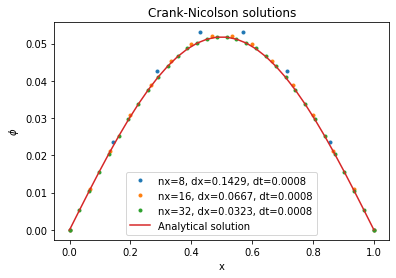

In [6]:
# Compute the solution for the various given grid steps
nt = 750
for nx in steps:
    cn = CrankNicolson1D(xbounds = x, tbounds = t, nx = nx, nt = nt, ic = ic, M = M)
    cn.fullsolve()

    plt.plot(cn.x, cn.solution, '.', label=f"nx={nx}, dx={cn.dx:.4f}, dt={cn.dt:.4f}")

# Plot the results
plt.plot(cn.x, ana(cn.x, t[1]), label="Analytical solution")
plt.legend()
plt.xlabel("x")
plt.ylabel(r"$\phi$")
plt.title("Crank-Nicolson solutions");

From the figure above we can see that the Crank-Nicolson method also converges to the Analytical solution given sufficient time steps. For the $n_x = 8$ case, as also discussed above at the Euler Backwards method, we would need more than $n_t = 750$ temporal points for proper convergence. However, similar to Euler Backward, this method shines at larger spatial grids. What we do notice however, even at these small spatial grid sizes, is that the solution seems to converge in much less time steps. This $n_t = 750$ result provides better convergence to the analytical solution compared to the Euler Backward's $n_t = 1250$ results. This is largely due to the fact that the error in time has decreased, from first order in Euler Backwards to second order in Crank-Nicolson. For larger spatial grids the reduction in the time error can lead to a more accurate result at the same amount of time steps or a quicker solution with the same accuracy compared to Euler Backwards, given that the time added by needing an extra matrix multiplication step every iteration is less than the time gained by using this method.

## Problem 2
### a.

Starting from the inital expression,
\begin{equation*}
    \frac{\partial \phi}{\partial t} = M\nabla^2 \phi = M\left(\frac{\partial^2 \phi}{\partial x^2} + \frac{\partial^2 \phi}{\partial y^2}\right).
\end{equation*}

The Euler Forward method used first order forward in time and second order central difference in space. Let $i$ denote the index in $x$, and $j$ the index in $y$, then we can write using eq. (14) from the lecture notes in time and twice eq. (22) from the lecture notes in space,
\begin{align*}
    \frac{\phi^{n+1}_{i,j} - \phi^n_{i,j}}{\Delta t} &= M\left(\frac{\phi^n_{i+1,j} - 2\phi^n_{i,j} + \phi^n_{i-1,j}}{(\Delta x)^2} + \frac{\phi^n_{i,j+1} - 2\phi^n_{i,j} + \phi^n_{i,j-1}}{(\Delta y)^2}\right) \\
    \phi^{n+1}_{i,j} &= \frac{M\Delta t}{(\Delta x)^2(\Delta y)^2}\left[(\Delta y)^2\left(\phi^n_{i+1,j} -2\phi^n_{i,j} + \phi^n_{i-1,j}\right) + (\Delta x)^2\left(\phi^n_{i,j+1} - 2\phi^n_{i,j} + \phi^n_{i,j-1}\right)\right] + \phi^n_{i,j}.
\end{align*}

Unfortunately we cannot clean up this equation quite so nicely has we could have in the 1D cases. We could define two separate $\alpha_x$ and $\alpha_y$, or write the prefactor on the right hand side as some factor, but this (seemingly) doesn't yield any benefits. To ensure the stability of this method, we are given a $\Delta t$ from eq. (4) of the assignment. This expression could also be derived from the Von Neumann stability condition (it probably has been).

### b.
The results will be presented in a similar fashion as in the 1D cases. The code and figures can be found below.

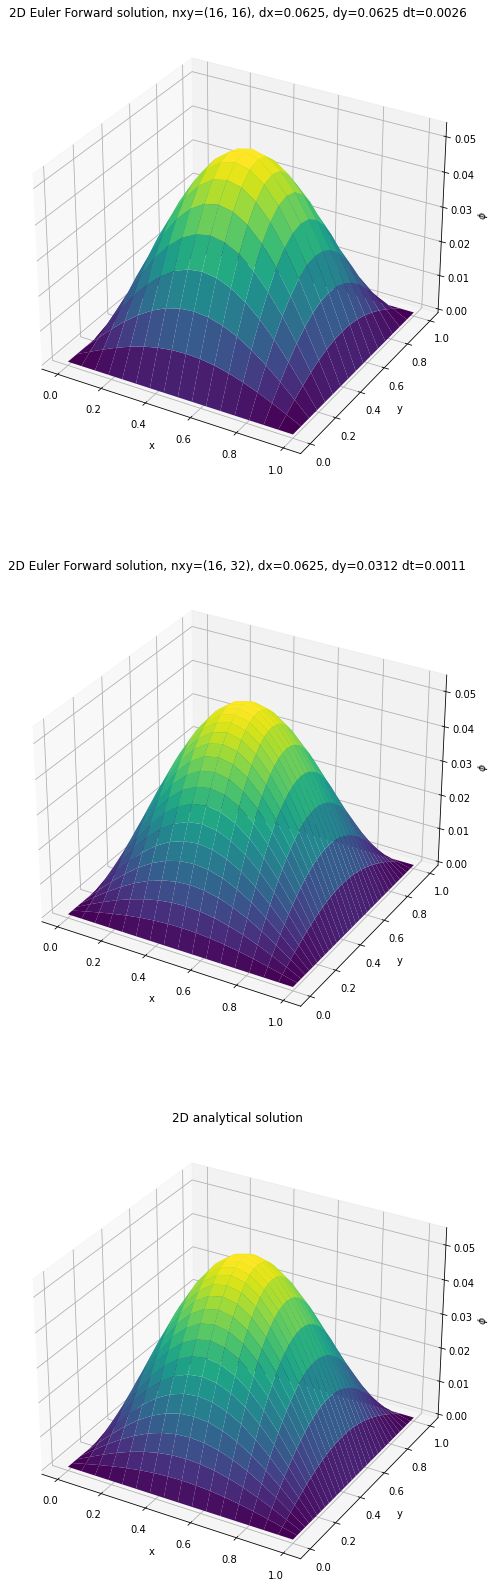

In [7]:
steps = ((16, 16), (16, 32))
xy = ((0, 1), (0, 1))
t = (0, 0.4)
M = 0.37

# Compute the initial conditions and analytical solution
ic = lambda x, y, _: np.sin(np.pi * x) * np.sin(np.pi * y)
ana = lambda x, y, t: np.exp(-2*M * np.pi**2 * t) * np.sin(np.pi * x) * np.sin(np.pi * y)

fig = plt.figure(figsize=(12.8, 3*9.6))

# Compute the solution for all given grid points in x
for i, nxy in enumerate(steps):
    nt = EulerForward2D.stable_time_steps(xy, t, nxy, M, nxy_as_interval=True)
    ef = EulerForward2D(xybounds = xy, tbounds = t, nxy = nxy, nt = nt, ic = ic, M = M)

    solution = ef.fullsolve()
    
    # Setup plot
    ax = fig.add_subplot(len(steps)+1, 1, i+1, projection="3d")
    ax.plot_surface(ef.meshx, ef.meshy, solution, cmap="viridis")
    plt.title(f"2D Euler Forward solution, nxy={nxy}, dx={ef.dx:.4f}, dy={ef.dy:.4f} dt={ef.dt:.4f}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel(r"$\phi$")

# Plot the analytical solution
ax = fig.add_subplot(len(steps)+1, 1, len(steps)+1, projection="3d")
ax.plot_surface(ef.meshx, ef.meshy, ana(ef.meshx, ef.meshy, t[1]), cmap="viridis")
plt.title(f"2D analytical solution")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel(r"$\phi$");


As we can see from the above figures, the 2D Euler Forward solutions seem to follow the analytical result fairly reasonably. The peak of the smaller spatial grid is a bit lower compared to the analytical solution, similar to the behaviour we have seen for the 1D Euler Forward method. Given enough spatial and temporal grid points, we have a good convergence.

### c.
# TODO!

## Problem 3
### a.
The goal is to discretise in Euler Forward the following differential expression,
\begin{equation*}
    \dot{\phi} = M\nabla^2(\phi^3 - \phi - \kappa \nabla^2\phi).
\end{equation*}

We will consider this problem in 1D, such that
\begin{align*}
    \frac{\partial \phi}{\partial t} &= M\frac{\partial^2}{\partial x^2}\left(\phi^3 - \phi - \kappa\frac{\partial^2 \phi}{\partial x^2}\right) \\
    &= M\left(\frac{\partial^2}{\partial x^2} \phi^3 - \frac{\partial^2}{\partial x^2} \phi - \kappa\frac{\partial^4}{\partial x^4}\phi\right).
\end{align*}

Let us discretise the three terms in brackets separately. We can replace the $\phi^3$ term with e.g. $f$, such that we can derive the discretisation for its second derivative identically to what has been done in the lecture notes. If we substitue $\phi^3$ back into $f$, we yield
\begin{align*}
    \frac{\partial^2}{\partial x^2} \phi^3 = \frac{\phi^3_{i+1} - 2\phi^3_i + \phi^3_{i-1}}{(\Delta x)^2}.
\end{align*}

We are already familiar with the second term,
\begin{equation*}
    \frac{\partial^2 \phi}{\partial x^2} = \frac{\phi_{i+1} - 2\phi_i + \phi_{i-1}}{(\Delta x)^2}.
\end{equation*}

The last term can be written as follows (using https://en.wikipedia.org/wiki/Finite_difference_coefficient for the required coefficients),
\begin{equation*}
    \frac{\partial^4 \phi}{\partial x^4} = \frac{\phi_{i+2} - 4\phi_{i+1} + 6\phi_i - 4\phi_{i-1} + \phi_{i-2}}{(\Delta x)^4}.
\end{equation*}

The left hand side time derivative is also already known. Filling everything in yields,
\begin{align*}
    \frac{\phi^{n+1}_i - \phi^n_i}{\Delta t} &= M\left[\frac{(\phi^3)^n_{i+1} - 2(\phi^3)^n_i + (\phi^3)^n_{i-1}}{(\Delta x)^2} - \frac{\phi^n_{i+1} - 2\phi^n_i + \phi^n_{i-1}}{(\Delta x)^2} - \kappa\frac{\phi^n_{i+2} - 4\phi^n_{i+1} + 6\phi^n_i - 4\phi^n_{i-1} + \phi^n_{i-2}}{(\Delta x)^4} \right] \\
    \phi^{n+1}_i &= \left(1 + 2\alpha - \frac{6\alpha\kappa}{(\Delta x)^2}\right)\phi^n_i + \left(-1 + \frac{4\kappa}{(\Delta x)^2}\right)\alpha\phi^n_{i+1} + \left(-1 + \frac{4\kappa}{(\Delta x)^2}\right)\alpha\phi^n_{i-1} +\\ &\alpha\left[(\phi^3)^n_{i+1} - 2(\phi^3)^n_i + (\phi^3)^n_{i-1} - \kappa\frac{\phi^n_{i+2} + \phi^n_{i-2}}{(\Delta x)^2}\right],
\end{align*}

which is the Euler Forward scheme we can implement.

### b.
As we have previously done, we will compute the solution to this more intricate problem using the Euler Forward method for various time steps. Again, we will use the suggested $\Delta t$ of eq. (7) from the assignment. We will take this as the required time step for a stable system, and use it to produce the results below, as a worst-case scenario.

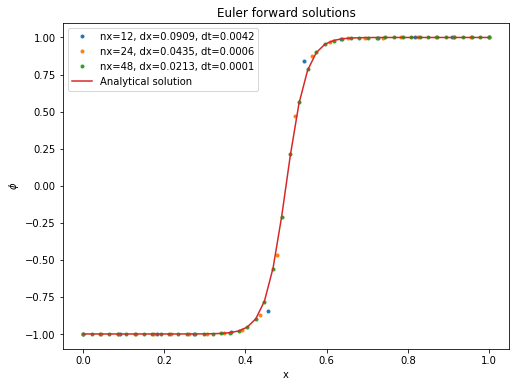

In [8]:
steps = (12, 24, 48)
x = (0, 1)
t = (0, 1)
M = 0.3
kappa = 1/768

# Compute the initial conditions and analytical solution
ic = lambda x, _: 2 * np.heaviside(x - 0.5, 0) - 1
ana = lambda x, t: np.tanh((x - 0.5) / np.sqrt(2*kappa))

plt.figure(figsize=(6.4*1.25, 4.8*1.25))
# Compute the solution for all given grid points in x
for nx in steps:
    nt = PhaseSepEulerForward1D.stable_time_steps(x, t, nx, M, kappa, nx_as_interval=True)
    ps = PhaseSepEulerForward1D(xbounds = x, tbounds = t, nx = nx, nt = nt, ic = ic, bc = (-1, 1), M = M)
    ps.set_kappa(kappa)

    ps.fullsolve()
    
    plt.plot(ps.x, ps.solution, '.', label=f"nx={nx}, dx={ps.dx:.4f}, dt={ps.dt:.4f}")

# Plot the results
plt.plot(ps.x, ana(ps.x, t[1]), label="Analytical solution")
plt.legend(loc="upper left")
plt.xlabel("x")
plt.ylabel(r"$\phi$")
plt.title("Euler forward solutions");

As we can see from the figure, we get good convergence onto the analytic result. We can see that the lowest spatial grid spacing has issues following the finer structure of the analytic solution due to its lack of resolution. The higher amounts of grid points have more points to follow the analytic shape.

### c.
In order for mass to be conserved, the continuity equation must hold. In this case, (from eq. (58) of the mathematics lecture notes),
\begin{align*}
    \dot{\phi} &= -\nabla \cdot \vec{J} \\
    &= M\nabla^2(\phi^3 - \phi - \kappa \nabla^2\phi).
\end{align*}

Now, we have a steady state, so this equation must equal zero. In other words,
\begin{equation*}
    \frac{\phi^{n+1}_i - \phi^n_i}{\Delta t} = 0.
\end{equation*}

Proving using Python, see the code below. We will integrate over the space to obtain the final result.

In [9]:
ps.cur_t -= 1
solution = copy.deepcopy(ps.solution)
next_solution = next(ps.solve())

total = np.trapz([(i - j)/ps.dt for i, j in zip(solution, next_solution)], dx = ps.dx)

print(f"The total difference in time integrated over space is {total}")

The total difference in time integrated over space is 3.885993182086381e-13


Now, I purpusefully didn't round the number in order to show that the order of magnutide is very small, in the range where rounding errors are going to affect the final result. So, we indeed show that we have a steady state, and so the mass is conserved in this system.

### d.
We will rerun the simulation, now for $n_x = 64$ to investigate the free energy. The reason for the increase in $n_x$ is because through trial-and-error we determined that more spatial grid points yielded a free energy closer and closer to the analytically expected value. The code and results are found below.

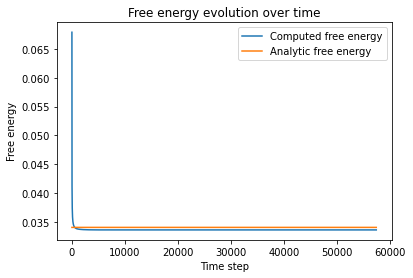

In [10]:
nx = 64
x_ana, dx_ana = np.linspace(*x, num=1000, retstep=True)

nt = PhaseSepEulerForward1D.stable_time_steps(x, t, nx, M, kappa, nx_as_interval=True)
ps = PhaseSepEulerForward1D(xbounds = x, tbounds = t, nx = nx, nt = nt, ic = ic, bc = (-1, 1), M = M)
ps.set_kappa(kappa)

F = np.zeros(nt)
sq = np.zeros(nt)
qu = np.zeros(nt)
grad = np.zeros(nt)

F_ana = np.trapz(-ana(x_ana, 0)**2 / 2 + ana(x_ana, 0)**4 / 4 + 1/4 + kappa/2 * np.gradient(ana(x_ana, 0), dx_ana)**2, x_ana)

for i, sol in enumerate(ps.solve()):
    sol = np.array(sol)
    F[i] = np.trapz(-sol**2 / 2 + sol**4 / 4 + 1/4 + kappa/2 * np.gradient(sol, ps.dx)**2, ps.x)

    sq[i] = np.trapz(-sol**2 / 2, ps.x)
    qu[i] = np.trapz(sol**4 / 4, ps.x)
    grad[i] = np.trapz(kappa/2 * np.gradient(sol, ps.dx)**2, ps.x)

plt.plot(range(nt - 1), F[:-1], label="Computed free energy")
plt.plot(range(nt - 1), F_ana * np.ones(nt-1), label="Analytic free energy")
plt.xlabel("Time step")
plt.ylabel("Free energy")
plt.legend()
plt.title("Free energy evolution over time");

We can clearly see in the figure that the free energy is indeed monotonically decreasing. There is a very rapid decay in the change of the free energy due to the system moving to an equilibrium state. Most of the time iterations are spent with only minor changes to the free energy, where we could consider it constant. Increasing the spatial grid size would yield results closer to the analytical value, altering the temporal grid does not influence the result much (as seen in the figure).

Let us now take a look at the contribution of each component.

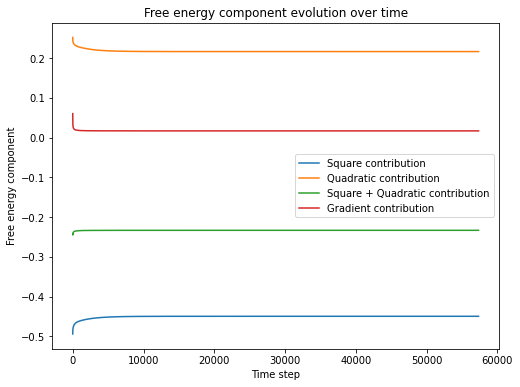

In [11]:
plt.figure(figsize=(6.4*1.25, 4.8*1.25))

plt.plot(range(nt - 1), sq[:-1], label="Square contribution")
plt.plot(range(nt - 1), qu[:-1], label="Quadratic contribution")
plt.plot(range(nt - 1), np.array(sq[:-1]) + np.array(qu[:-1]), label="Square + Quadratic contribution")
plt.plot(range(nt - 1), grad[:-1], label="Gradient contribution")
plt.xlabel("Time step")
plt.ylabel("Free energy component")
plt.legend()
plt.title("Free energy component evolution over time");

This figure provides good insight into how the monotonic decrease in the free energy is composed. Due to the sign difference in the square and the quadratic terms provide opposite contributions, as well as being scaled. What is interesting however, is when they are both added together their summed contribution is actually monotonically increasing! We can also see that the additional $\frac{1}{4}$ term that has been added in eq. (7) from the assignment (but that is missing in the literature of Cates & Tjhung) is roughly to compensate for the sum of these terms for "large" $t$.

Of note is then that the gradient term is the sole reason that the free energy is monotinically decreasing, and that is mostly its sole purpose. In the first iterations, the gradient is sufficiently large such as to overcome the small size of $\kappa$. However, as we converge towards the analytic solution, the gradient of $\phi$ decreases, making this contribution to the free energy significantly less, mostly due to the small value of $\kappa$.